# Logistic Regression: Titanic Problem


- This is a Classification Problem where we have to predict if a person Survived the Titanic Shipwreck or not.
- We are given a dataset with labels attached to it (0 - did not survive, 1 - survived, in the `Survived` column)
- First of all, we split the dataset into train/validation/test. This is an essential step in any machine learning problem.
- We keep the validation and test sets aside, only fitting them to preprocessing transformations. 
- The transformations we use are (a) StandardScaler() for `Age` and `Fare`, since they are numeric columns, and (b) OneHotEncoder for `Sex` and `Embarked`, since they are categorical columns. The rest of the columns are already in a small range (0-10) so it is not necessary to standardize them.
- We look at histograms of survivors/non-survivors amongst different columns, and use the intuition developed there to consider three new categorical features.
- Next, in order to fit the best possible model, we consider a number of possible hyperparameters, and, fitting a Logistic Regression model to each of them, compute the training and validation loss. The set(s) of hyperparameters that have the least validation loss are the "optimal" hyperparameters for our case. 
- The model with the best hyperparameters (lowest validation loss) is then used to generate predictions for the test set, and the loss and accuracy in the test set are computed. 
- Finally, we can predict the labels for the dataset whose labels are unknown to us (the `submission_dataset`) and submit them to the Kaggle competition. 

We get a score (accuracy) of $0.77511$

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
dataset = pd.read_csv('/kaggle/input/titanic/train.csv')
submission_dataset = pd.read_csv('/kaggle/input/titanic/test.csv')

In [3]:
dataset = dataset.set_index('PassengerId')
submission_dataset = submission_dataset.set_index('PassengerId')

In [4]:
dataset.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
dataset.shape

(891, 11)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Note that the 'Cabin' data is extremely incomplete, and it is thus unlkely to have much predictive power. We will drop this column. Next, we are left with 'Age' and 'Embarked' columns with some missing values. We may try to deal with this by:
- droppung the rows where 'embarked' is missing, since they correspond to a miniscule ~0.2% of the data
- for age, we can use a KNN imputer that estimates the missing age based on the average of the ages of the people "most similar" in terms of features. We use a weighted kNN, where the weight of the closest point is higher and decreases as the point moves further away. This is done once the dataset has been split into train/validation/test since we do not want to fit the imputer to data that it should not be aware of (validation/test).

Note: We do the train_test_split with stratify=y, so that the three datasets (train/val/test) have roughly the same proportions of class labels.

Before we can run the kNN imputer, we need to clean up our data.
- We do not need the people's names. This column can be dropped.
- The 'Sex' column can be one-hot encoded with 0 or 1 (is Male or not)
- The 'Embarked' column also needs to be one-hot encoded.
- The ticket number is also dropped. It is a string quantity and seems unlikely that it has a direct effect on survivability.

In [7]:
dataset = dataset.drop(['Cabin', 'Name', 'Ticket'], axis=1)
dataset = dataset.dropna(subset=['Embarked'])

In [8]:
submission_dataset = submission_dataset.drop(['Cabin', 'Name', 'Ticket'], axis=1)
#submission_dataset = submission_dataset.dropna(subset=['Embarked'])

In [9]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first')
em_encoder = OneHotEncoder(drop='first')

In [10]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(weights = 'distance')

In [11]:
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(dataset.drop('Survived', axis=1),
                                                    dataset['Survived'],
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify=dataset['Survived'])

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.25,
                                                    random_state = 42,
                                                    stratify=y)

print(f"The shape of the training data is: X_train={X_train.shape}, y_train = {y_train.shape}")
print(f"The shape of the validation data is: X_val={X_val.shape}, y_val = {y_val.shape}")
print(f"The shape of the testing data is: X_test = {X_test.shape}, y_test = {y_test.shape}")

The shape of the training data is: X_train=(499, 7), y_train = (499,)
The shape of the validation data is: X_val=(167, 7), y_val = (167,)
The shape of the testing data is: X_test = (223, 7), y_test = (223,)


In [12]:
X_train['Sex'] = encoder.fit_transform(np.array(X_train['Sex']).reshape(-1,1)).toarray()
X_val['Sex'] = encoder.transform(np.array(X_val['Sex']).reshape(-1,1)).toarray()
X_test['Sex'] = encoder.transform(np.array(X_test['Sex']).reshape(-1,1)).toarray()

In [13]:
submission_dataset['Sex'] = encoder.transform(np.array(submission_dataset['Sex']).reshape(-1,1)).toarray()

In [14]:
X_train[['Embarked_1', 'Embarked_2']]=em_encoder.fit_transform(np.array(X_train['Embarked']).reshape(-1,1)).toarray()
X_train = X_train.drop('Embarked',axis=1)

X_test[['Embarked_1', 'Embarked_2']]=em_encoder.transform(np.array(X_test['Embarked']).reshape(-1,1)).toarray()
X_test = X_test.drop('Embarked',axis=1)

X_val[['Embarked_1', 'Embarked_2']]=em_encoder.transform(np.array(X_val['Embarked']).reshape(-1,1)).toarray()
X_val = X_val.drop('Embarked',axis=1)

In [15]:
submission_dataset[['Embarked_1', 'Embarked_2']]=em_encoder.transform(np.array(submission_dataset['Embarked']).reshape(-1,1)).toarray()
submission_dataset = submission_dataset.drop('Embarked',axis=1)

In [16]:
X_train.shape

(499, 8)

In [17]:
submission_dataset.isnull().sum() # we need to impute Fare as well.

Pclass         0
Sex            0
Age           86
SibSp          0
Parch          0
Fare           1
Embarked_1     0
Embarked_2     0
dtype: int64

In [18]:
X_train['Age'] = knn_imputer.fit_transform(X_train)[:,2]
X_test['Age'] = knn_imputer.transform(X_test)[:,2]
X_val['Age'] = knn_imputer.transform(X_val)[:,2]

In [19]:
submission_dataset['Age'], submission_dataset['Fare'] = knn_imputer.transform(submission_dataset)[:,2],knn_imputer.transform(submission_dataset)[:,5]

In [20]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_1,Embarked_2
PassengerId,,,,,,,,
723,2,1.0,34.000000,0,0,13.0000,0.0,1.0
242,3,0.0,26.720642,1,0,15.5000,1.0,0.0
678,3,0.0,18.000000,0,0,9.8417,0.0,1.0
688,3,1.0,19.000000,0,0,10.1708,0.0,1.0
211,3,1.0,24.000000,0,0,7.0500,0.0,1.0


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [23]:
X_train[['Age', 'Fare']] = scaler.fit_transform(X_train[['Age', 'Fare']])
X_test[['Age', 'Fare']] = scaler.transform(X_test[['Age', 'Fare']])
X_val[['Age', 'Fare']] = scaler.transform(X_val[['Age', 'Fare']])

In [24]:
submission_dataset[['Age', 'Fare']] = scaler.transform(submission_dataset[['Age', 'Fare']])

In [25]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_1,Embarked_2
PassengerId,,,,,,,,
723,2,1.0,0.300373,0,0,-0.383382,0.0,1.0
242,3,0.0,-0.235753,1,0,-0.330854,1.0,0.0
678,3,0.0,-0.878030,0,0,-0.449741,0.0,1.0
688,3,1.0,-0.804380,0,0,-0.442827,0.0,1.0
211,3,1.0,-0.436129,0,0,-0.508398,0.0,1.0
...,...,...,...,...,...,...,...,...
619,2,0.0,-1.909132,2,1,0.162906,0.0,1.0
361,3,1.0,0.742274,1,4,-0.070317,0.0,1.0
605,1,1.0,0.374023,0,0,-0.098682,0.0,0.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

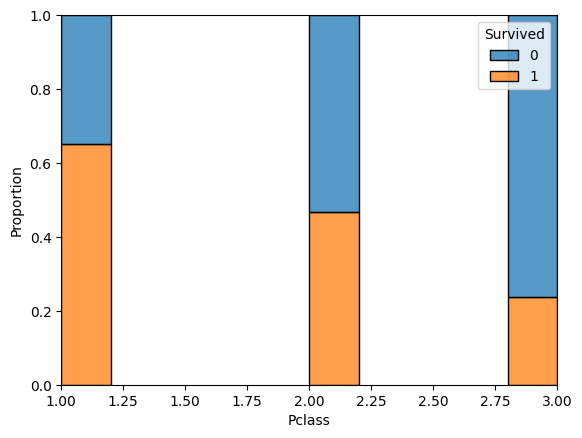

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

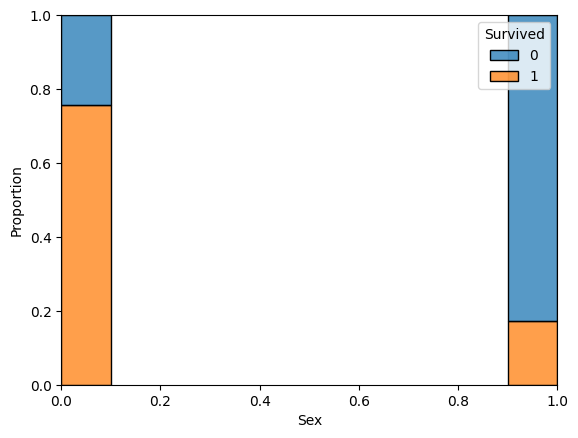

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

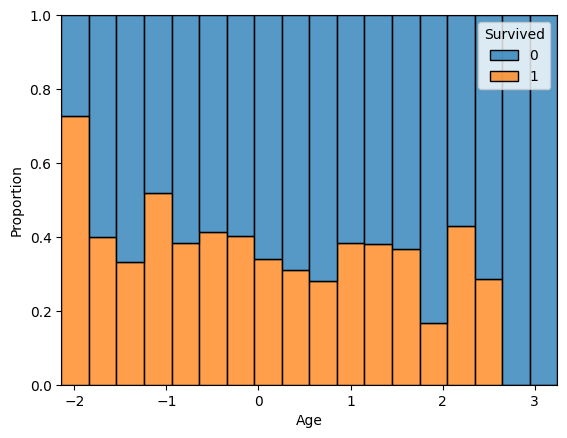

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

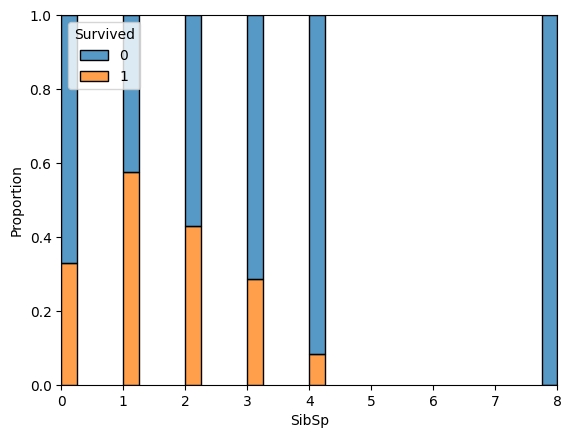

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

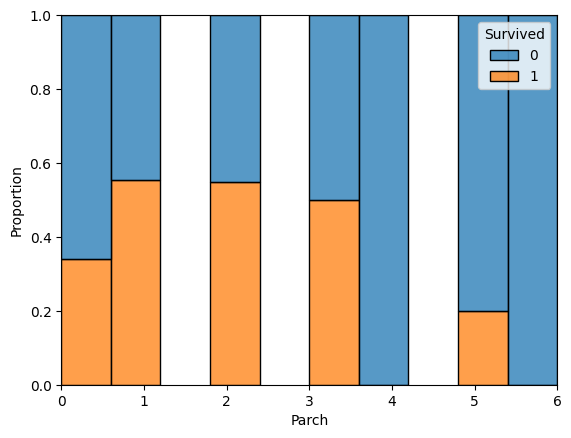

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

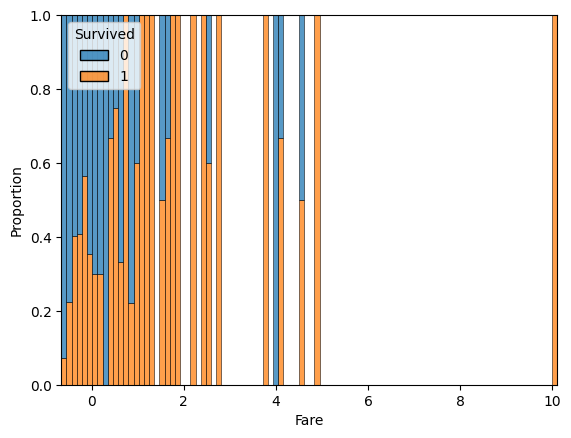

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

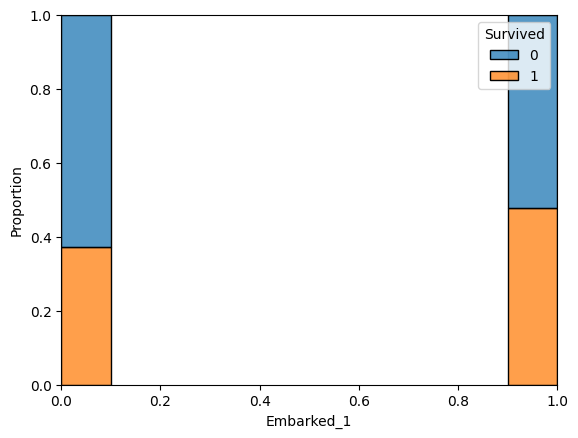

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

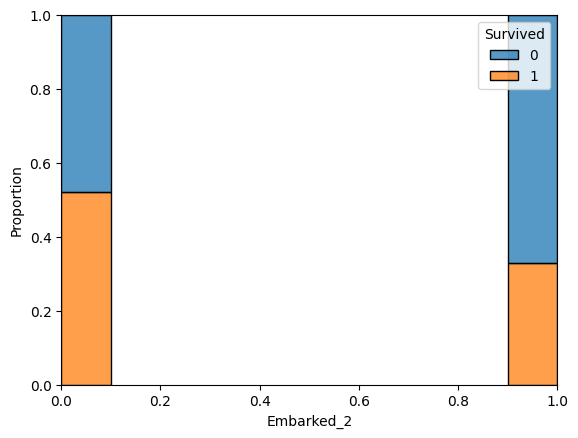

In [26]:
for x_col in list(X_train.columns):
    sns.histplot(data=X_train,x=x_col, hue=y_train, stat='proportion', multiple='fill')
    plt.show()

After we normalize the data, we look at some of the key features of the dataset.
This can be done by plotting scatterplots. This:
- gives us a better intution on what the data looks like before and after transformation
- allows us to get a more comprehensive understanding of the relationships between the columns and the predictor

We do see a few patterns:
- Survival chances seem to decrease as one goes from first to third class
- Females (sex = 0) are more likely to survive than males (sex=1)
- Very young people (normalized age ~ -2) are most likely to survive, followed by slow decrease with age.
- People with 0-2 siblings are most likely to survive and this decreases with increasing siblings.
- people with 1-3 parents/children aboard are most likely to survive.
- There is a rough correlation between fare and survival chances.
- The place of embarkation seems to matter.

Based on this, we may engineer a few new features:
- Age <= -1
- Sibsp <= 2
- Parch <= 3

In [27]:
X_train['age-leq-neg1'] = np.float64(X_train['Age'] <= -1)
X_train['sibsp-leq-2'] = np.float64(X_train['SibSp'] <= 2)
X_train['Parch-leq-3'] = np.float64(X_train['Parch'] <= 3)

X_test['age-leq-neg1'] = np.float64(X_test['Age'] <= -1)
X_test['sibsp-leq-2'] = np.float64(X_test['SibSp'] <= 2)
X_test['Parch-leq-3'] = np.float64(X_test['Parch'] <= 3)

X_val['age-leq-neg1'] = np.float64(X_val['Age'] <= -1)
X_val['sibsp-leq-2'] = np.float64(X_val['SibSp'] <= 2)
X_val['Parch-leq-3'] = np.float64(X_val['Parch'] <= 3)

In [28]:
submission_dataset['age-leq-neg1'] = np.float64(submission_dataset['Age'] <= -1)
submission_dataset['sibsp-leq-2'] = np.float64(submission_dataset['SibSp'] <= 2)
submission_dataset['Parch-leq-3'] = np.float64(submission_dataset['Parch'] <= 3)

In [29]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_1,Embarked_2,age-leq-neg1,sibsp-leq-2,Parch-leq-3
PassengerId,,,,,,,,,,,
723,2,1.0,0.300373,0,0,-0.383382,0.0,1.0,0.0,1.0,1.0
242,3,0.0,-0.235753,1,0,-0.330854,1.0,0.0,0.0,1.0,1.0
678,3,0.0,-0.878030,0,0,-0.449741,0.0,1.0,0.0,1.0,1.0
688,3,1.0,-0.804380,0,0,-0.442827,0.0,1.0,0.0,1.0,1.0
211,3,1.0,-0.436129,0,0,-0.508398,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
619,2,0.0,-1.909132,2,1,0.162906,0.0,1.0,1.0,1.0,1.0
361,3,1.0,0.742274,1,4,-0.070317,0.0,1.0,0.0,1.0,0.0
605,1,1.0,0.374023,0,0,-0.098682,0.0,0.0,0.0,1.0,1.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

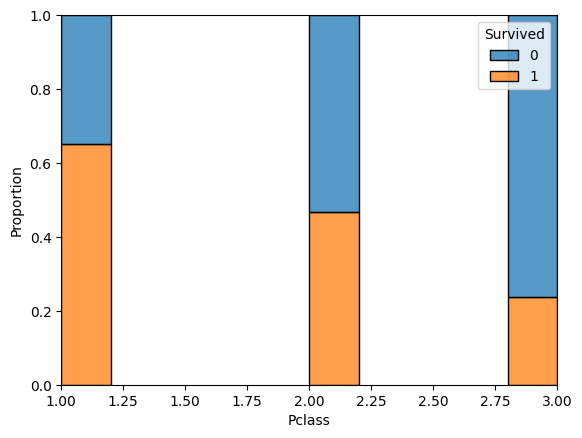

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

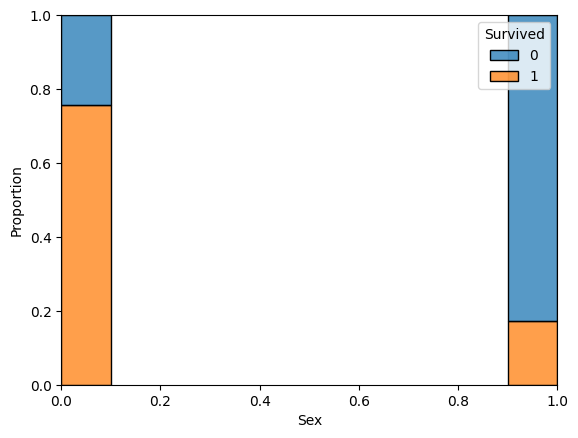

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

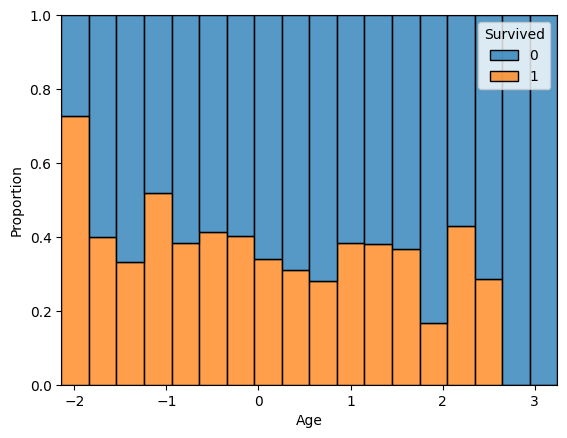

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

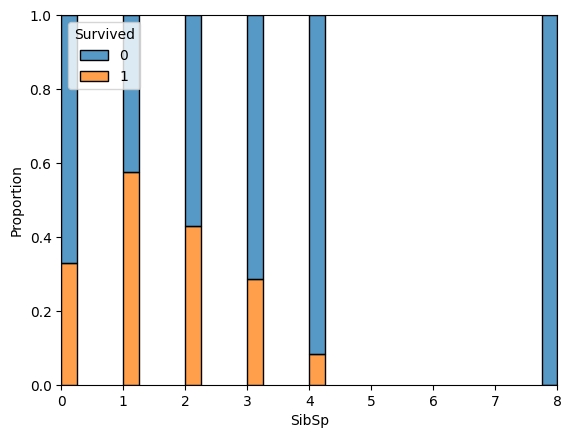

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

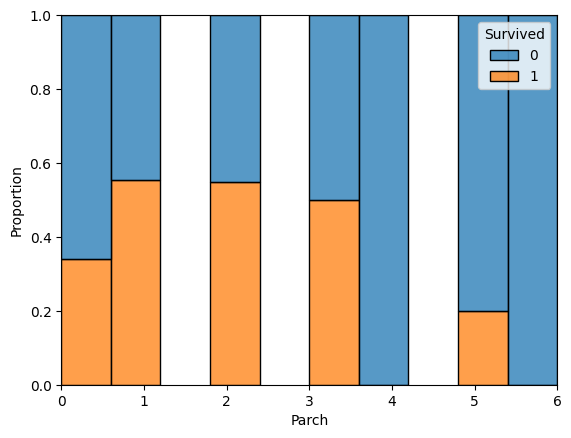

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

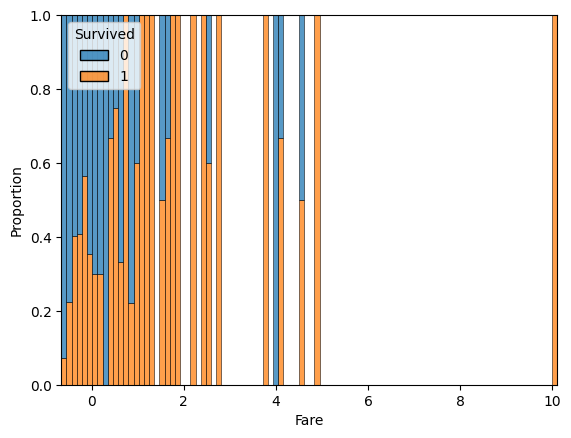

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

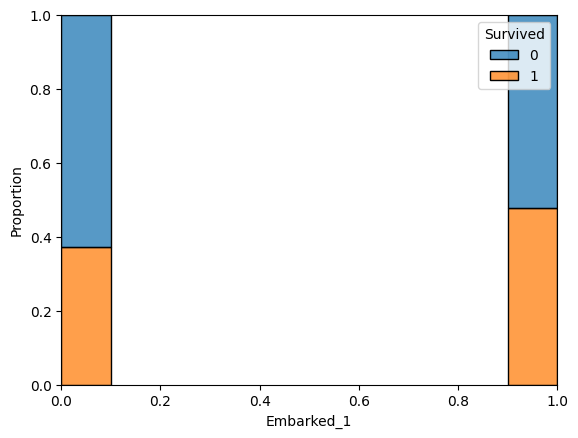

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

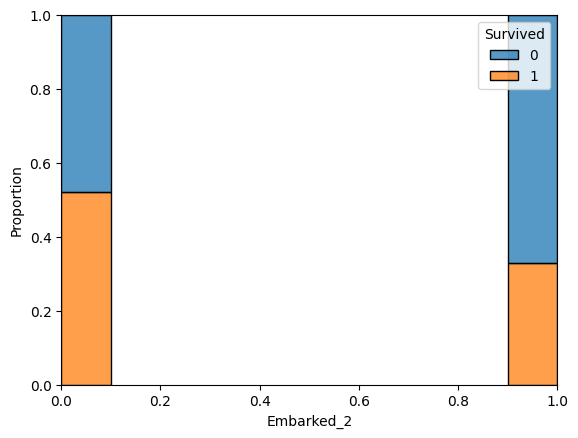

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

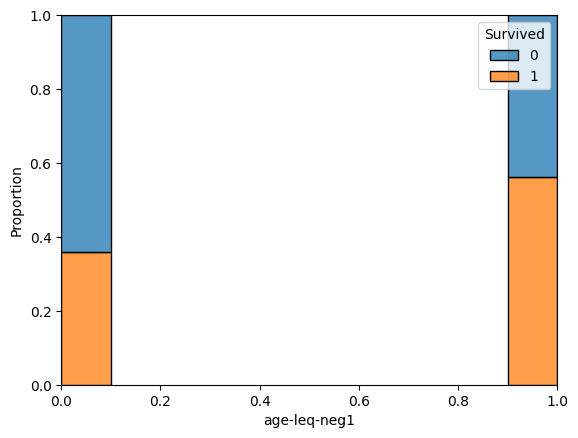

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

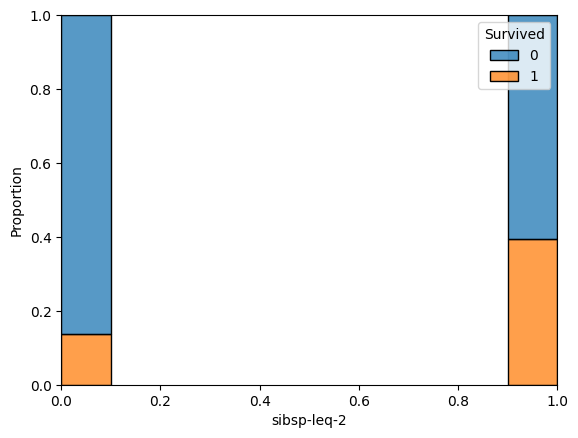

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

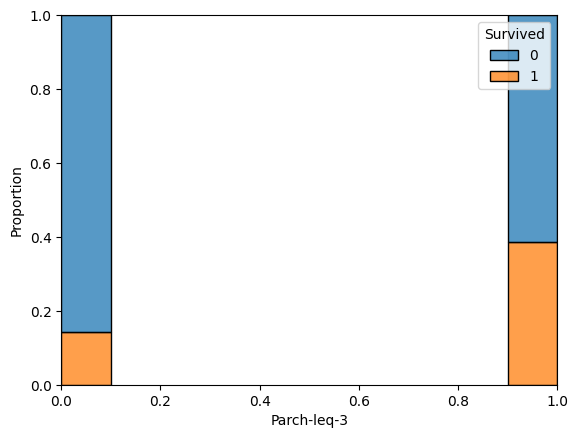

In [30]:
for x_col in list(X_train.columns):
    sns.histplot(data=X_train,x=x_col, hue=y_train, stat='proportion', multiple='fill')
    plt.show()

We are now ready to train a logistic regression model to this data.

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import ParameterGrid
def parameter_search(penalty, dual, tol, C, class_weight, random_state, solver, max_iter):
    results = []
    param_dict = {'penalty': penalty,
                 'dual': dual,
                 'tol': tol,
                 'C': C,
                 'class_weight': class_weight,
                 'random_state': random_state,
                 'solver': solver,
                 'max_iter': max_iter}
    param_grid = ParameterGrid(param_dict)
    for param in param_grid:
        logistic_regression_classifier = LogisticRegression().set_params(**param)                                                                               
        logistic_regression_classifier.fit(X_train, y_train)
        y_pred_train = logistic_regression_classifier.predict_proba(X_train)
        y_pred_val = logistic_regression_classifier.predict_proba(X_val)
        train_loss = log_loss(y_train, y_pred_train, normalize=True)
        val_loss = log_loss(y_val, y_pred_val, normalize=True)
        results.append([param['penalty'], param['dual'], 
                        param['tol'], param['C'], param['class_weight'], param['random_state'],
                        param['solver'], param['max_iter'], train_loss, val_loss])
    
    res = pd.DataFrame(results)
    res.columns = ["penalty", "dual", "tol", "C", "class_weight", "random_state", "solver", "max_iter", "train_loss", "val_loss"]
    return res

In [32]:
loss_df = parameter_search(penalty=["l1", "l2"],
                           dual=[False],
                           tol = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
                           C = [0.25,0.5,1,2,4,5, 6,7,8],
                           class_weight=['balanced',None],
                           random_state=[42],
                           solver=['saga'],
                           max_iter=[1000,2000,3000,4000,5000,6000,7000,8000])

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [33]:
loss_df

,penalty,dual,tol,C,class_weight,random_state,solver,max_iter,train_loss,val_loss
0,l1,False,0.00001,0.25,balanced,42,saga,1000,0.427834,0.516749
1,l1,False,0.00010,0.25,balanced,42,saga,1000,0.427877,0.516634
2,l1,False,0.00100,0.25,balanced,42,saga,1000,0.428206,0.515783
3,l1,False,0.01000,0.25,balanced,42,saga,1000,0.427505,0.498164
4,l1,False,0.10000,0.25,balanced,42,saga,1000,0.445944,0.493607
...,...,...,...,...,...,...,...,...,...,...
2011,l2,False,0.00100,8.00,None,42,saga,8000,0.400828,0.501401
2012,l2,False,0.01000,8.00,None,42,saga,8000,0.402122,0.493368
2013,l2,False,0.10000,8.00,None,42,saga,8000,0.423866,0.487018
2014,l2,False,1.00000,8.00,None,42,saga,8000,0.500811,0.530049


In [34]:
loss_df.describe()

,tol,C,random_state,max_iter,train_loss,val_loss
count,2016.000000,2016.00000,2016.0,2016.000000,2016.000000,2016.000000
mean,1.587301,3.75000,42.0,4500.000000,0.447829,0.513879
std,3.452014,2.76454,0.0,2291.856335,0.054836,0.028079
min,0.000010,0.25000,42.0,1000.000000,0.400607,0.486349
25%,0.000100,1.00000,42.0,2750.000000,0.408121,0.494255
50%,0.010000,4.00000,42.0,4500.000000,0.418234,0.501439
75%,1.000000,6.00000,42.0,6250.000000,0.500871,0.530083
max,10.000000,8.00000,42.0,8000.000000,0.563638,0.580177


In [35]:
loss_df_l2_solvers = parameter_search(penalty=["l2"],
                           dual=[False],
                           tol = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
                           C = [0.25,0.5,1,2,4,5, 6,7,8],
                           class_weight=['balanced',None],
                           random_state=[42],
                           solver=['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
                           max_iter=[1000,2000,3000,4000,5000,6000,7000,8000])

In [36]:
loss_df_l2_solvers

,penalty,dual,tol,C,class_weight,random_state,solver,max_iter,train_loss,val_loss
0,l2,False,0.00001,0.25,balanced,42,lbfgs,1000,0.427217,0.505167
1,l2,False,0.00010,0.25,balanced,42,lbfgs,1000,0.427217,0.505167
2,l2,False,0.00100,0.25,balanced,42,lbfgs,1000,0.427217,0.505167
3,l2,False,0.01000,0.25,balanced,42,lbfgs,1000,0.427214,0.505172
4,l2,False,0.10000,0.25,balanced,42,lbfgs,1000,0.427170,0.505069
...,...,...,...,...,...,...,...,...,...,...
6043,l2,False,0.00100,8.00,None,42,saga,8000,0.400828,0.501401
6044,l2,False,0.01000,8.00,None,42,saga,8000,0.402122,0.493368
6045,l2,False,0.10000,8.00,None,42,saga,8000,0.423866,0.487018
6046,l2,False,1.00000,8.00,None,42,saga,8000,0.500811,0.530049


In [37]:
loss_df_l2_solvers.describe()

,tol,C,random_state,max_iter,train_loss,val_loss
count,6048.000000,6048.000000,6048.0,6048.000000,6048.000000,6048.000000
mean,1.587301,3.750000,42.0,4500.000000,0.429261,0.506509
std,3.451443,2.764083,0.0,2291.477296,0.051686,0.032428
min,0.000010,0.250000,42.0,1000.000000,0.400615,0.483166
25%,0.000100,1.000000,42.0,2750.000000,0.402806,0.495963
50%,0.010000,4.000000,42.0,4500.000000,0.415678,0.500559
75%,1.000000,6.000000,42.0,6250.000000,0.424896,0.502057
max,10.000000,8.000000,42.0,8000.000000,0.693147,0.693147


Now we can find the optimal parameters, as those that minimize the validation loss. They can be found (for the fixed-solver and fixed-penalty case respectively) as:

In [38]:
loss_df[loss_df['val_loss'] == np.min(loss_df['val_loss'])]

,penalty,dual,tol,C,class_weight,random_state,solver,max_iter,train_loss,val_loss
1796,l1,False,0.1,8.0,balanced,42,saga,1000,0.436992,0.486349
1810,l1,False,0.1,8.0,balanced,42,saga,2000,0.436992,0.486349
1824,l1,False,0.1,8.0,balanced,42,saga,3000,0.436992,0.486349
1838,l1,False,0.1,8.0,balanced,42,saga,4000,0.436992,0.486349
1852,l1,False,0.1,8.0,balanced,42,saga,5000,0.436992,0.486349
1866,l1,False,0.1,8.0,balanced,42,saga,6000,0.436992,0.486349
1880,l1,False,0.1,8.0,balanced,42,saga,7000,0.436992,0.486349
1894,l1,False,0.1,8.0,balanced,42,saga,8000,0.436992,0.486349


In [39]:
loss_df_l2_solvers[loss_df_l2_solvers['val_loss'] == np.min(loss_df_l2_solvers['val_loss'])]

,penalty,dual,tol,C,class_weight,random_state,solver,max_iter,train_loss,val_loss
5738,l2,False,1.0,8.0,None,42,newton-cholesky,1000,0.424484,0.483166
5739,l2,False,10.0,8.0,None,42,newton-cholesky,1000,0.424484,0.483166
5780,l2,False,1.0,8.0,None,42,newton-cholesky,2000,0.424484,0.483166
5781,l2,False,10.0,8.0,None,42,newton-cholesky,2000,0.424484,0.483166
5822,l2,False,1.0,8.0,None,42,newton-cholesky,3000,0.424484,0.483166
5823,l2,False,10.0,8.0,None,42,newton-cholesky,3000,0.424484,0.483166
5864,l2,False,1.0,8.0,None,42,newton-cholesky,4000,0.424484,0.483166
5865,l2,False,10.0,8.0,None,42,newton-cholesky,4000,0.424484,0.483166
5906,l2,False,1.0,8.0,None,42,newton-cholesky,5000,0.424484,0.483166
5907,l2,False,10.0,8.0,None,42,newton-cholesky,5000,0.424484,0.483166


Thus the best model, the one with the lowest training and validation loss, is actually one from the `loss_df_l2_solvers` dataframe (note that there are multiple choices) and can be found as:

In [40]:
best_params = loss_df_l2_solvers[loss_df_l2_solvers['val_loss'] == np.min(loss_df_l2_solvers['val_loss'])].iloc[0]

In [41]:
classifier = LogisticRegression().set_params(**dict(best_params[:-2]))

In [42]:
classifier.fit(X_train, y_train)

LogisticRegression(C=8.0, max_iter=1000, random_state=42,
                   solver='newton-cholesky', tol=1.0)

In [43]:
y_pred_test = classifier.predict_proba(X_test)
print("The loss on the test dataset is:",log_loss(y_test, y_pred_test, normalize=True))

The loss on the test dataset is: 0.4705253393082119


In [44]:
print("The train accuracy is:", classifier.score(X_train, y_train))
print("The validation accuracy is:", classifier.score(X_val, y_val))
print("The test accuracy is:", classifier.score(X_test, y_test))

The train accuracy is: 0.8276553106212425
The validation accuracy is: 0.7964071856287425
The test accuracy is: 0.8026905829596412


In [45]:
y_pred = classifier.predict(submission_dataset)

In [46]:
submission_dataset['Survived'] = y_pred

In [47]:
submission_dataset['Survived'].to_csv('submission.csv', index=True,header=True)